When you use BertForQuestionAnswering, the model automatically adds a task-specific head, but its weights are randomly initialized because it wasn't part of the pre-training process.

In [ ]:
# Install the required datasets library version
!pip install datasets==2.14.6

# from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, get_scheduler
from torch.utils.data import DataLoader
from transformers import default_data_collator
from accelerate import Accelerator
from tqdm.auto import tqdm
import torch
import numpy as np
import collections
from huggingface_hub import Repository, get_full_repo_name

# Load SQuAD dataset
raw_datasets = load_dataset("squad")
print(raw_datasets)

# Load the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Define max_length and stride for tokenization
max_length = 384
stride = 128

# Preprocess training examples
def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)

        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

        if offset[context_start][0] <= start_char and offset[context_end][1] >= end_char:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        else:
            start_positions.append(0)
            end_positions.append(0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

# Preprocess validation examples
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

# Apply preprocessing to the datasets
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

# Prepare the datasets for DataLoader
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler setup
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Accelerator setup
# accelerator = Accelerator(fp16=True)
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

# Metric computation function
from datasets import load_metric

metric = load_metric("squad")

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -20 - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -20 - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > 30
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    start_logits = []
    end_logits = []
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained("bert-finetuned-squad-accelerate", save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained("bert-finetuned-squad-accelerate")


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

  0%|          | 0/33198 [00:00<?, ?it/s]

  0%|          | 0/1348 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

NameError: name 'metric' is not defined

In [1]:
# Install the required datasets library version
!pip install datasets==2.14.6

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, get_scheduler
from torch.utils.data import DataLoader
from transformers import default_data_collator
from accelerate import Accelerator
from tqdm.auto import tqdm
import torch
import numpy as np
import collections
from huggingface_hub import Repository, get_full_repo_name

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.


In [3]:
# Load SQuAD dataset
from datasets import load_dataset

raw_datasets = load_dataset("squad")
print(raw_datasets)

# Load the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Define max_length and stride for tokenization
max_length = 384
stride = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Preprocess training examples
def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)

        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

        if offset[context_start][0] <= start_char and offset[context_end][1] >= end_char:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        else:
            start_positions.append(0)
            end_positions.append(0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

# Preprocess validation examples
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs


In [5]:
# Apply preprocessing to the datasets
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [6]:

validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [7]:
# Prepare the datasets for DataLoader
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

In [8]:
# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler setup
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Accelerator setup
!pip install --upgrade accelerate

from accelerate import Accelerator

# Enable mixed-precision explicitly
accelerator = Accelerator(mixed_precision="fp16")  # Use 'bf16' for TPUs if needed

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)


In [11]:
# Metric computation function
from datasets import load_metric

metric = load_metric("squad")

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -20 - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -20 - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > 30
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)



<ipython-input-11-a648142f4ed7>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad")


In [12]:
# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    start_logits = []
    end_logits = []
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained("bert-finetuned-squad-accelerate", save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained("bert-finetuned-squad-accelerate")

  0%|          | 0/33198 [00:00<?, ?it/s]

  0%|          | 0/1348 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

epoch 0: {'exact_match': 78.37275307473983, 'f1': 86.55043387485553}


  0%|          | 0/1348 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

epoch 1: {'exact_match': 80.4162724692526, 'f1': 87.94820025046995}


  0%|          | 0/1348 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

epoch 2: {'exact_match': 79.96215704824976, 'f1': 88.0576032566704}


In [13]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'score': 0.9978997707366943,
 'start': 78,
 'end': 105,
 'answer': 'Jax, PyTorch and TensorFlow'}

In [ ]:
'''
def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []


    # Track the last processed sample index
    last_sample_idx = -1

    for i, offset in enumerate(inputs["offset_mapping"]):
        # Check which sample the current chunk belongs to
        sample_idx = inputs["overflow_to_sample_mapping"][i]

        # If we're processing a new sample, reset the answer found flag
        if sample_idx != last_sample_idx:
            last_sample_idx = sample_idx

        # Extract the answer details for the current sample
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])

        # Identify the context boundaries using sequence IDs
        sequence_ids = inputs.sequence_ids(i)

        # Find where the context starts and ends
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx

        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Check if the answer is fully inside the chunk
        if offset[context_start][0] <= start_char and offset[context_end][1] >= end_char:
            # The answer is fully inside the chunk; find its start and end positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        else:
            # If the answer is not in this chunk, append (0, 0)
            start_positions.append(0)
            end_positions.append(0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs
'''

In [ ]:
'''
def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs
'''






# Extractive question answering
- This involves posing questions about a document and identifying the answers as spans of text in the document itself.

:https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt

0. fine-tune a BERT model on the SQuAD dataset, which consists of questions posed by crowdworkers on a set of Wikipedia articles.
1. Encoder-only models like BERT tend to be great at extracting answers to factoid questions like “Who invented the Transformer architecture?” but fare poorly when given open-ended questions like “Why is the sky blue?” In these more challenging cases, encoder-decoder models like T5 and BART are typically used to synthesize the information in a way that’s quite similar to text summarization.
2. Dataset: The dataset that is used the most as an academic benchmark for extractive question answering is SQuAD, so that’s the one we’ll use here. There is also a harder SQuAD v2 benchmark, which includes questions that don’t have an answer.
3. The context and question fields are  straightforward. The answers field is  a dictionary with two fields that are both lists:

Answer: {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}

answer_start field contains the starting character index of each answer in the context.

In [ ]:
!pip install datasets==2.14.6

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
!pip install datasets==2.14.6
from datasets import load_dataset

raw_datasets = load_dataset("squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
!pip install datasets==2.14.6
from datasets import load_dataset

raw_datasets = load_dataset("squad")
print(raw_datasets)


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
!pip install datasets==2.14.6
from datasets import load_dataset

raw_datasets = load_dataset("squad")
print(raw_datasets)
print("Context: ", raw_datasets["train"][10]["context"])
print("Question: ", raw_datasets["train"][10]["question"])
print("Answer: ", raw_datasets["train"][10]["answers"])

Context:  The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
Question:  Where is the headquarters of the Congregation of the Holy Cross?
Answer:  {'text': ['Rome'], 'answer_start': [119]}


In [ ]:
# check for one long context

for i, entry in enumerate(raw_datasets["train"]):
    if len(entry["context"]) > 2000:
        print(f"ID: {i}\nContext:\n{entry['context']}")
        break

ID: 2359
Context:
Van Praag states that the Ming court established diplomatic delegations with Tibet merely to secure urgently needed horses. Wang and Nyima argue that these were not diplomatic delegations at all, that Tibetan areas were ruled by the Ming since Tibetan leaders were granted positions as Ming officials, that horses were collected from Tibet as a mandatory "corvée" tax, and therefore Tibetans were "undertaking domestic affairs, not foreign diplomacy". Sperling writes that the Ming simultaneously bought horses in the Kham region while fighting Tibetan tribes in Amdo and receiving Tibetan embassies in Nanjing. He also argues that the embassies of Tibetan lamas visiting the Ming court were for the most part efforts to promote commercial transactions between the lamas' large, wealthy entourage and Ming Chinese merchants and officials. Kolmaš writes that while the Ming maintained a laissez-faire policy towards Tibet and limited the numbers of the Tibetan retinues, the Tibetans

In [ ]:
len(raw_datasets["train"][2359]['context'])

2132

In [ ]:
# tokenizer.is_fast


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset


raw_datasets = load_dataset("squad")

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
raw_datasets["train"][2359]["context"]

'Van Praag states that the Ming court established diplomatic delegations with Tibet merely to secure urgently needed horses. Wang and Nyima argue that these were not diplomatic delegations at all, that Tibetan areas were ruled by the Ming since Tibetan leaders were granted positions as Ming officials, that horses were collected from Tibet as a mandatory "corvée" tax, and therefore Tibetans were "undertaking domestic affairs, not foreign diplomacy". Sperling writes that the Ming simultaneously bought horses in the Kham region while fighting Tibetan tribes in Amdo and receiving Tibetan embassies in Nanjing. He also argues that the embassies of Tibetan lamas visiting the Ming court were for the most part efforts to promote commercial transactions between the lamas\' large, wealthy entourage and Ming Chinese merchants and officials. Kolmaš writes that while the Ming maintained a laissez-faire policy towards Tibet and limited the numbers of the Tibetan retinues, the Tibetans sought to maint

In [ ]:
context = raw_datasets["train"][2359]["context"]
question = raw_datasets["train"][2359]["question"]

# number of tokens in the context is -> Tokenize the context without truncation
tokens = tokenizer(context, truncation=False)

# Print the number of tokens
print("Number of tokens in context:", len(tokens["input_ids"]))

Number of tokens in context: 441


In [ ]:
inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] Why does Van Praag believe the Ming court set up a diplomatic delegation with Tibet? [SEP] Van Praag states that the Ming court established diplomatic delegations with Tibet merely to secure urgently needed horses. Wang and Nyima argue that these were not diplomatic delegations at all, that Tibetan areas were ruled by the Ming since Tibetan leaders were granted positions as Ming officials, that horses were collected from Tibet as a mandatory " corvée " tax, and therefore Tibetans were " undertaking domestic affairs, not foreign diplomacy ". Sperling writes that the Ming simultaneously bought horses in the Kham region while fighting Tibetan tribes in Amdo and receiving Tibetan embassies in Nanjing. He also argues that the embassies of Tibetan lamas visiting the Ming court were for the most part efforts to promote commercial transactions between the lamas \' large, wealthy entourage and Ming Chinese merchants and officials. Kolmaš writes that while the Ming maintained a laissez - 

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=384,
    truncation="only_second",
    stride=100,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,

)

# Display each chunk
for i, ids in enumerate(inputs["input_ids"]):
    print(f"Chunk {i + 1}:\n")
    print(tokenizer.decode(ids, skip_special_tokens=True))  # Decode token IDs to text
    print("\n" + "=" * 80 + "\n")

Chunk 1:

Why does Van Praag believe the Ming court set up a diplomatic delegation with Tibet? Van Praag states that the Ming court established diplomatic delegations with Tibet merely to secure urgently needed horses. Wang and Nyima argue that these were not diplomatic delegations at all, that Tibetan areas were ruled by the Ming since Tibetan leaders were granted positions as Ming officials, that horses were collected from Tibet as a mandatory " corvée " tax, and therefore Tibetans were " undertaking domestic affairs, not foreign diplomacy ". Sperling writes that the Ming simultaneously bought horses in the Kham region while fighting Tibetan tribes in Amdo and receiving Tibetan embassies in Nanjing. He also argues that the embassies of Tibetan lamas visiting the Ming court were for the most part efforts to promote commercial transactions between the lamas ' large, wealthy entourage and Ming Chinese merchants and officials. Kolmaš writes that while the Ming maintained a laissez - fair

In [ ]:
print(inputs['offset_mapping'][1])

[(0, 0), (0, 3), (4, 8), (9, 12), (13, 14), (14, 16), (16, 18), (19, 26), (27, 30), (31, 35), (36, 41), (42, 45), (46, 48), (49, 50), (51, 61), (62, 72), (73, 77), (78, 83), (83, 84), (0, 0), (1341, 1342), (1343, 1347), (1348, 1350), (1351, 1357), (1358, 1361), (1361, 1363), (1363, 1364), (1365, 1371), (1372, 1378), (1378, 1379), (1380, 1381), (1381, 1385), (1385, 1388), (1389, 1392), (1393, 1401), (1402, 1409), (1410, 1413), (1414, 1423), (1424, 1434), (1434, 1435), (1436, 1439), (1440, 1444), (1444, 1445), (1446, 1449), (1450, 1455), (1456, 1459), (1460, 1465), (1465, 1466), (1467, 1468), (1468, 1471), (1472, 1478), (1479, 1480), (1480, 1482), (1483, 1486), (1487, 1493), (1494, 1496), (1497, 1501), (1502, 1513), (1514, 1520), (1521, 1523), (1524, 1527), (1528, 1532), (1533, 1538), (1539, 1541), (1542, 1546), (1547, 1549), (1550, 1555), (1556, 1557), (1557, 1560), (1561, 1563), (1564, 1569), (1569, 1570), (1571, 1574), (1575, 1579), (1579, 1581), (1582, 1589), (1590, 1593), (1594, 159

In [ ]:
raw_datasets["train"][2359]["answers"]

{'text': ['to secure urgently needed horses'], 'answer_start': [90]}

In [ ]:
context = raw_datasets["train"][2359]["context"]
question = raw_datasets["train"][2359]["question"]
answer = raw_datasets["train"][2359]["answers"]
answer

{'text': ['to secure urgently needed horses'], 'answer_start': [90]}

In [ ]:
answer['answer_start'][0] + len(answer['text'][0])

122

In [ ]:
context[90:122]

'to secure urgently needed horses'

# Label the features/ chunks

The above information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

(0, 0) if the answer is not in the corresponding span of the context
(start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

[(0, 0), (0, 3), (4, 8), (9, 12), (13, 14), (14, 16), (16, 18), (19, 26), (27, 30), (31, 35), (36, 41), (42, 45), (46, 48), (49, 50), (51, 61), (62, 72), (73, 77), (78, 83), (83, 84), (0, 0), (0, 3), (4, 5), (5, 7), (7, 9), (10, 16), (17, 21), (22, 25), (26, 30), (31, 36), (37, 48), (49, 59), (60, 70), (70, 71), (72, 76), (77, 82), (83, 89), (90, 92), (93, 99), (100, 106), (106, 108), (109, 115), (116, 122), (122, 123), (124, 128), (129, 132), (133, 134), (134, 136), (136, 138), (139, 144), (145, 149), (150, 155), (156, 160), (161, 164), (165, 175), (176, 186), (186, 187), (188, 190), (191, 194), (194, 195), (196, 200), (201, 208), (209, 214), (215, 219), (220, 225), (226, 228), (229, 232), (233, 237), (238, 243), (244, 251), (252, 259), (260, 264), (265, 272), (273, 282), (283, 285), (286, 290), (291, 300), (300, 301), (302, 306), (307, 313), (314, 318), (319, 328), (329, 333), (334, 339), (340, 342), (343, 344), (345, 354), (355, 356), (356, 358), (358, 359), (359, 360), (360, 362), 

In [ ]:
# it means there are two chunks
inputs["overflow_to_sample_mapping"]

[0, 0]

# Data labeling example
 Check the labelling for examples from 2359:2365 index positions

In [ ]:
answer["answer_start"]

[90]

In [ ]:
answers = raw_datasets["train"][2359:2365]["answers"]
answers

[{'text': ['to secure urgently needed horses'], 'answer_start': [90]},
 {'text': ['Silk workshops'], 'answer_start': [1980]},
 {'text': ['Tibetan Buddhist'], 'answer_start': [2103]},
 {'text': ['the Ming'], 'answer_start': [22]},
 {'text': ['a mandatory "corvée" tax'], 'answer_start': [343]},
 {'text': ['Tibet'], 'answer_start': [42]}]

In [ ]:
# i want to tokenize exmaples from 2359 to 2365
inputs = tokenizer(
    raw_datasets["train"][2359:2365]["question"],
    raw_datasets["train"][2359:2365]["context"],
    max_length=384,
    truncation="only_second",
    stride=100,
    return_overflowing_tokens=True,
    return_offsets_mapping=True
)

In [ ]:
inputs

{'input_ids': [[101, 2009, 1674, 3605, 153, 1611, 8517, 2059, 1103, 12590, 2175, 1383, 1146, 170, 8311, 11703, 1114, 13659, 136, 102, 3605, 153, 1611, 8517, 2231, 1115, 1103, 12590, 2175, 1628, 8311, 11703, 1116, 1114, 13659, 5804, 1106, 5343, 14844, 1193, 1834, 4697, 119, 7014, 1105, 151, 10279, 1918, 6982, 1115, 1292, 1127, 1136, 8311, 11703, 1116, 1120, 1155, 117, 1115, 12046, 1877, 1127, 4741, 1118, 1103, 12590, 1290, 12046, 3478, 1127, 3609, 3638, 1112, 12590, 3878, 117, 1115, 4697, 1127, 4465, 1121, 13659, 1112, 170, 11839, 107, 1884, 1197, 1964, 8533, 107, 3641, 117, 1105, 3335, 12046, 1116, 1127, 107, 20686, 4500, 5707, 117, 1136, 2880, 24500, 107, 119, 156, 3365, 1979, 6474, 1115, 1103, 12590, 7344, 3306, 4697, 1107, 1103, 148, 2522, 1805, 1229, 2935, 12046, 6872, 1107, 7277, 2572, 1105, 4172, 12046, 9712, 16531, 23434, 1107, 23761, 119, 1124, 1145, 8935, 1115, 1103, 9712, 16531, 23434, 1104, 12046, 2495, 7941, 5807, 1103, 12590, 2175, 1127, 1111, 1103, 1211, 1226, 3268, 1106,

In [ ]:
len(inputs['input_ids'][0])==len(inputs['offset_mapping'][0])

True

In [ ]:
# there are total 11 chunks assigned for 2359:2365 examples
print(len(inputs["offset_mapping"]))

11


In [ ]:
# now we iterate over all the chunks or features one by one and find the corresponding labels
for i, offset in enumerate(inputs["offset_mapping"]):
  print(i, offset)
  print(len(offset))

0 [(0, 0), (0, 3), (4, 8), (9, 12), (13, 14), (14, 16), (16, 18), (19, 26), (27, 30), (31, 35), (36, 41), (42, 45), (46, 48), (49, 50), (51, 61), (62, 72), (73, 77), (78, 83), (83, 84), (0, 0), (0, 3), (4, 5), (5, 7), (7, 9), (10, 16), (17, 21), (22, 25), (26, 30), (31, 36), (37, 48), (49, 59), (60, 70), (70, 71), (72, 76), (77, 82), (83, 89), (90, 92), (93, 99), (100, 106), (106, 108), (109, 115), (116, 122), (122, 123), (124, 128), (129, 132), (133, 134), (134, 136), (136, 138), (139, 144), (145, 149), (150, 155), (156, 160), (161, 164), (165, 175), (176, 186), (186, 187), (188, 190), (191, 194), (194, 195), (196, 200), (201, 208), (209, 214), (215, 219), (220, 225), (226, 228), (229, 232), (233, 237), (238, 243), (244, 251), (252, 259), (260, 264), (265, 272), (273, 282), (283, 285), (286, 290), (291, 300), (300, 301), (302, 306), (307, 313), (314, 318), (319, 328), (329, 333), (334, 339), (340, 342), (343, 344), (345, 354), (355, 356), (356, 358), (358, 359), (359, 360), (360, 362)

In [ ]:
# the tokenizer gives us chunks as features if the sample size > max_len. to label each chunk, we need to know if the answer is present
#  in the chunk or not. To know this, we idenfity which sample, a chunk is coming from?
# overflow_to_sample_mapping-> gives us the chunk and its corresponding sample information

# now, look for the presence of answer in all the chunks. look for the index of the offset where the answer is present in each chunk else assign 0,0 as label
# first, find start and end char of the answer in our sample

# find which sample the chunk is coming from? it means 9th chunk is coming from 4th exmaple (2359, 2360, 2361, 2362, 2363, 2364)
# 0,1 chunk. -> sample 0
# 2, 3 chunk -> sample 1
# 4 chunk -> sample 2
# 8 chunk -> sample 4
# 10 chunk -> sample 5

inputs["overflow_to_sample_mapping"][10]

5

In [ ]:
# answer of 5th sample (2363)
answers[4]

{'text': ['a mandatory "corvée" tax'], 'answer_start': [343]}

In [ ]:
# i want to label examples from 2359 to 2365 (we extract the token index number where the ans is present in each chunk)
answers = raw_datasets["train"][2359:2365]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
  # finding from which sample each chunk coming from ?
  # sample_idx= 0, it means chunk 0 is from sample 0
  sample_idx = inputs["overflow_to_sample_mapping"][i]

  answer = answers[sample_idx]

  start_char = answer["answer_start"][0]
  # end_char= 296
  end_char = answer["answer_start"][0] + len(answer["text"][0])
  # sequence_ids gives info where the context starts. offset begins with question followed by context, we only focus on the context
  # sequence_ids= [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]
  sequence_ids = inputs.sequence_ids(i)

  idx=0
  while(sequence_ids[idx]!=1):
    idx+=1
  context_start = idx
  # context_start=17 (ans starts at 17 index), now look for ans in offset starting from 17 position
  # now, check where the context ends? start from context_start unitl the end, the last position is where the context ends, index is 98

  while(sequence_ids[idx]==1):
    idx+=1
  # here, idx = 99 but context ends at 98 index
  context_end = idx - 1

  # If the answer is not fully inside the chunk, assing label as (0, 0)
  #  since first chunk fully contains the answer, this condition becomes false, so we look for the start and end postion where the ans exists in the chunk
  if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
    start_positions.append(0)
    end_positions.append(0)

  else:
    # look for the answer positions, start from context id (context_start), also iterate till end
    # idx=17, context_end= 99 (look for start_positions in between 17 and 99 only)
    idx= context_start
    while offset[idx][0] <= start_char and idx <= context_end:
      idx+=1
    start_positions.append(idx-1)

    # look for end_position from the end (context_end)
    idx= context_end
    while idx >= context_start and end_char <= offset[idx][1]:
      idx-=1
    end_positions.append(idx+1)

In [ ]:
# this is exmaple assuming max_length =100, and stride= 50
# start_positions = []
# end_positions = []

# # i represents all chunks, offset is char positions in every chunk
# # start from, i=0, fist chunk, offset is start and end char positions in chunk 0
# for i, offset in enumerate(inputs["offset_mapping"]):
#   # finding from which sample each chunk coming from ?
#   # sample_idx= 0, it means chunk 0 is from sample 0
#   sample_idx = inputs["overflow_to_sample_mapping"][i]
#   # answer of first sample = {'text': ['the Main Building'], 'answer_start': [279]}
#   answer= answers[sample_idx]
#   # start_char= 279 , now, look for 279 in first four chunks
#   start_char = answer["answer_start"][0]
#   # end_char= 296
#   end_char = answer["answer_start"][0] + len(answer["text"][0])
#   # sequence_ids gives info where the context starts. offset begins with question followed by context, we only focus on the context
#   # sequence_ids= [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]
#   sequence_ids = inputs.sequence_ids(i)

#   idx=0
#   while(sequence_ids[idx]!=1):
#     idx+=1
#   context_start = idx
#   # context_start=17 (ans starts at 17 index), now look for ans in offset starting from 17 position
#   # now, check where the context ends? start from context_start unitl the end, the last position is where the context ends, index is 98

#   while(sequence_ids[idx]==1):
#     idx+=1
#   # here, idx = 99 but context ends at 98 index
#   context_end = idx - 1

#   # If the answer is not fully inside the chunk, assing label as (0, 0)
#   #  since first chunk fully contains the answer, this condition becomes false, so we look for the start and end postion where the ans exists in the chunk
#   if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
#     start_positions.append(0)
#     end_positions.append(0)

#   else:
#     # look for the answer positions, start from context id (context_start), also iterate till end
#     # idx=17, context_end= 99 (look for start_positions in between 17 and 99 only)
#     idx= context_start
#     while offset[idx][0] <= start_char and idx <= context_end:
#       idx+=1
#     start_positions.append(idx-1)

#     # look for end_position from the end (context_end)
#     idx= context_end
#     while idx >= context_start and end_char <= offset[idx][1]:
#       idx-=1
#     end_positions.append(idx+1)

# start_positions, end_positions

optimized code: if the answer does not exist in the current chunk (is not fully contained within the current chunk), it makes sense to skip the remaining chunks for the same sample, as the answer will not appear in subsequent overlapping chunks.
 the expected output indicates that multiple chunks for different samples might still need to be evaluated, even if the answer is not present in the current chunk. However, once a chunk of a specific sample fully contains the answer, subsequent chunks for the same sample can be skipped.

 Optimized Code Advantages
Handles Skipping:

If the answer is in an early chunk, the optimized code stops processing subsequent chunks, reducing the number of iterations.
Best-Case Complexity:

For answers in the first chunk, complexity is significantly reduced to O(n * L), making it much faster than the original code.
Practical Scenarios:

In real-world datasets, answers are often found in earlier chunks (as chunking tries to preserve answer spans). This makes the optimized approach more efficient in practice.
Original Code Advantages
Simplicity:

The original code is easier to implement and understand, as it uniformly processes all chunks.
Edge Cases:

The original code ensures no chunks are skipped incorrectly, as it processes all chunks. The optimized code requires careful implementation to avoid skipping incorrectly.


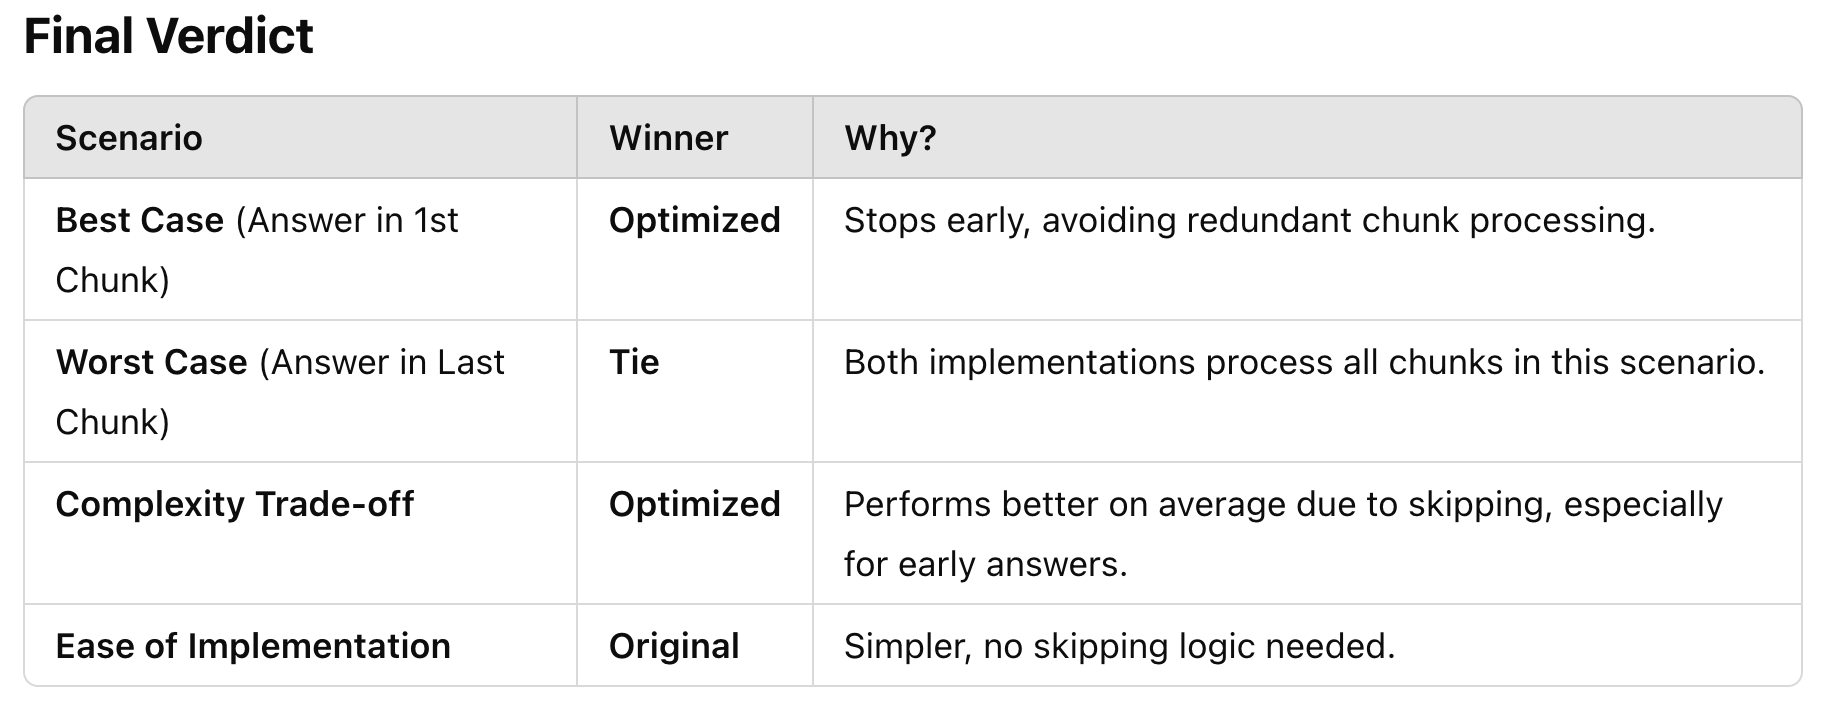


<!--  -->

# 3. preprocess_training_examples (Actual code)

In [ ]:
raw_datasets["train"].column_names

['id', 'title', 'context', 'question', 'answers']

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
  # cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything

    questions = [q.strip() for q in examples["question"]]

    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []


    # Track the last processed sample index
    last_sample_idx = -1

    for i, offset in enumerate(offset_mapping):
        # Check which sample the current chunk /belongs to
        sample_idx = sample_map[i]

        # If we're processing a new sample, reset the answer found flag
        if sample_idx != last_sample_idx:
            last_sample_idx = sample_idx

        # Extract the answer details for the current sample
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])

        # Identify the context boundaries using sequence IDs
        sequence_ids = inputs.sequence_ids(i)

        # Find where the context starts and ends
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx

        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Check if the answer is fully inside the chunk
        if offset[context_start][0] <= start_char and offset[context_end][1] >= end_char:
            # The answer is fully inside the chunk; find its start and end positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        else:
            # If the answer is not in this chunk, append (0, 0)
            start_positions.append(0)
            end_positions.append(0)

    start_positions, end_positions

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

1. preprocess_training_examples: This is the preprocessing function that is applied to the dataset. It defines how each example (or batch of examples) is transformed. For instance, it might tokenize text, add special tokens, or format inputs for a model.
2. batched=True: This specifies that the map function processes data in batches rather than processing one example at a time.
3. remove_columns=raw_datasets["train"].column_names: This removes the original columns from the dataset after the preprocessing step.
Why remove columns? After preprocessing, the original data (e.g., raw text) might no longer be needed, as it is replaced with processed data (e.g., tokenized input IDs). Removing unused columns can save memory and make the resulting dataset cleaner.


In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    # raw_datasets["train"].column_names= ['context', 'question', 'answers']
    remove_columns=raw_datasets["train"].column_names,
)


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 88729
})

In [ ]:
len(raw_datasets["train"]), len(train_dataset)


(87599, 88729)

In [ ]:
88729-87599

1130

# 4. Processing the validation data

- Preprocessing the validation data (testing on unseen data)
-


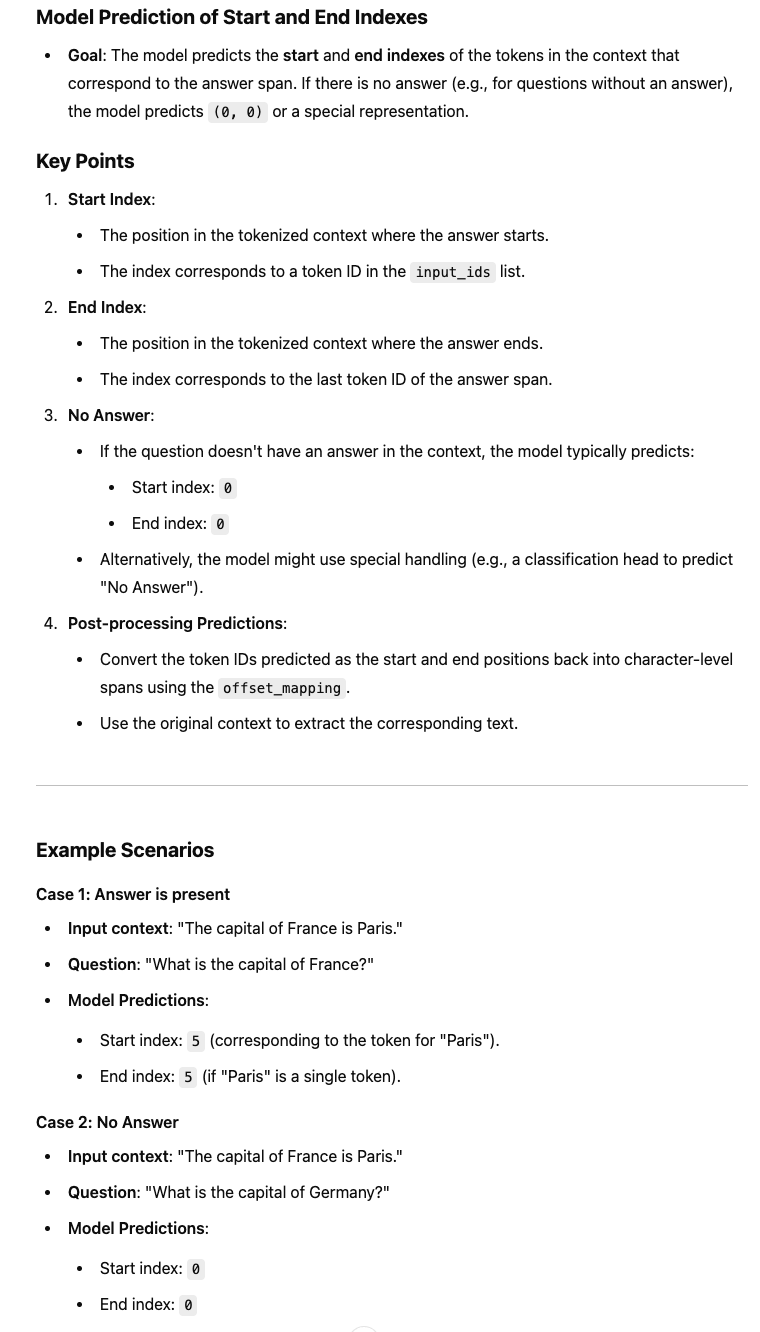

In [ ]:
raw_datasets["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

# 5. Preparing DataLoader

We set the format of those datasets to "torch", and remove the columns in the validation set that are not used by the model. Then, we can use the default_data_collator provided by Transformers as a collate_fn and shuffle the training set, but not the validation set


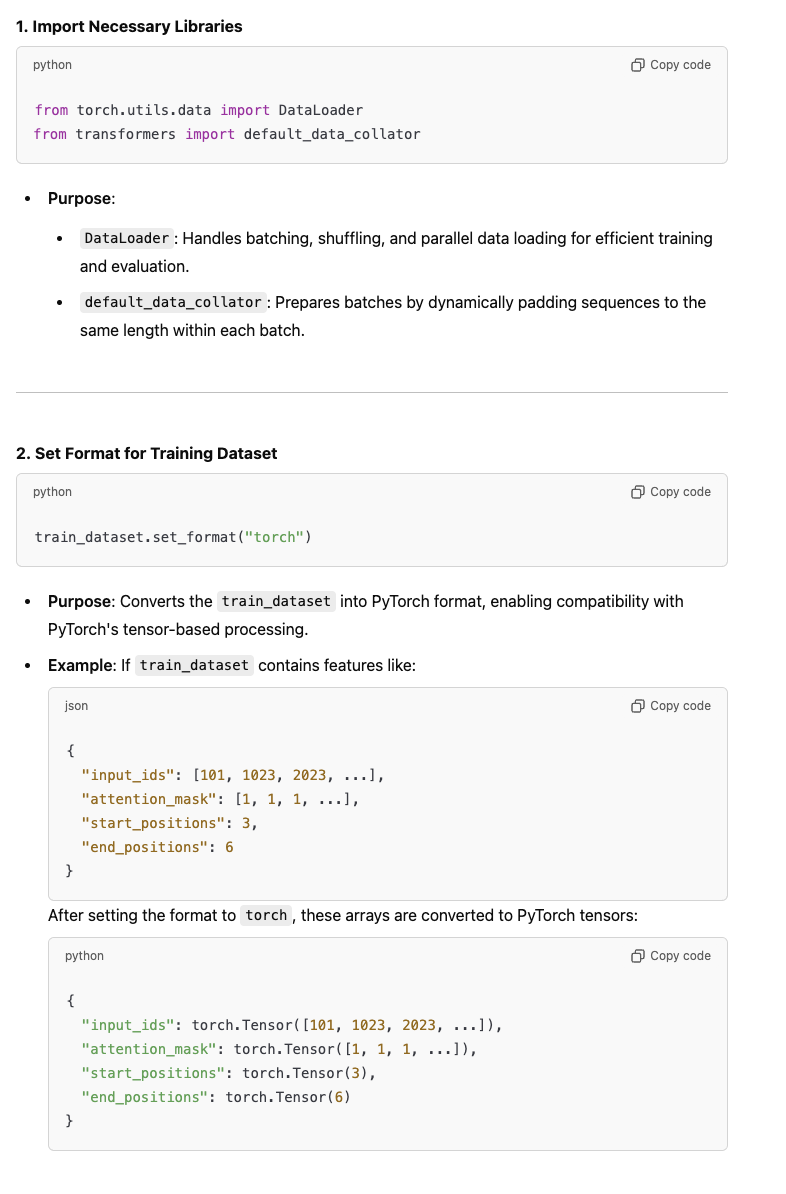

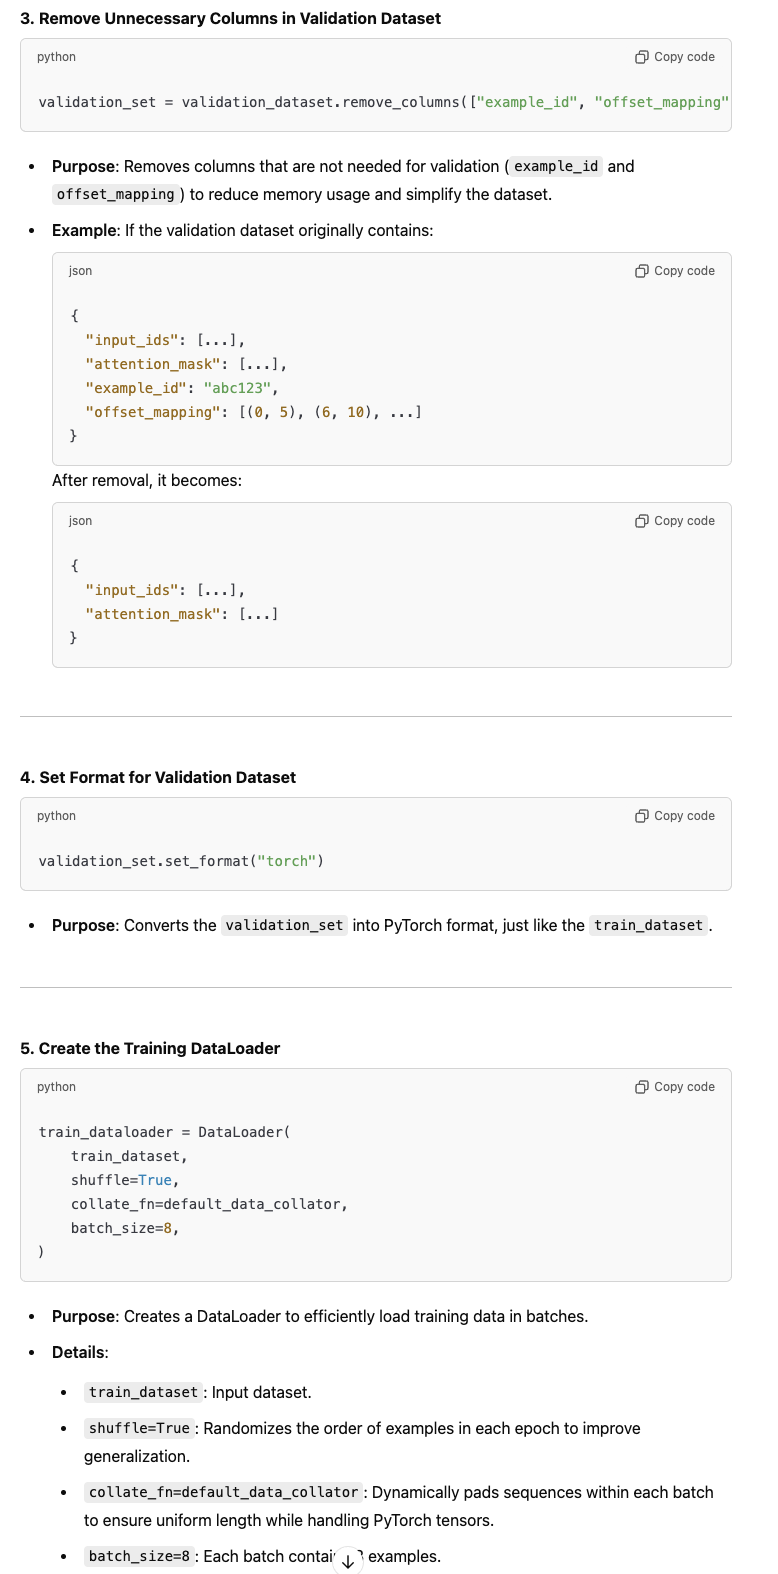

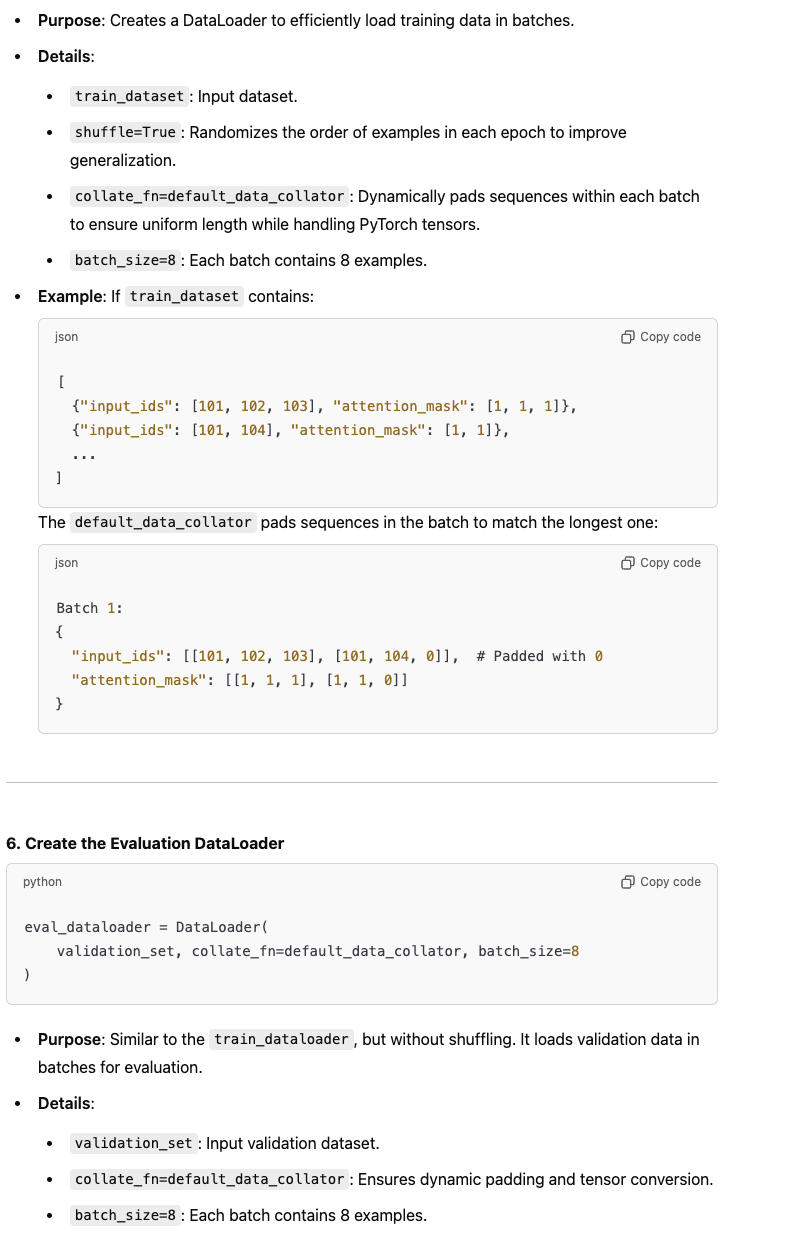

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

# 5. Fine-tuning the model with the Trainer API


1. set some hyperparameters (like the learning rate, the number of epochs we train for, and some weight decay) and indicate that we want to save the model at the end of every epoch, skip evaluation, and upload our results to the Model Hub. We also enable mixed-precision training with fp16=True, as it can speed up the training nicely on a recent GPU.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)


In [ ]:
# Then we will need an optimizer. As usual we use the classic AdamW, which is like Adam, but with a fix in the way weight decay is applied:

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
!pip install transformers accelerate


In [ ]:
# Finally, we just pass everything to the Trainer class and launch the training:
#  while the training happens, each time the model is saved (here, every epoch) it is uploaded to the Hub in the background. This way, you will be able to to resume your training on another machine if necessary.
# Also note that as soon as the first epoch is finished, you will see some weights uploaded to the Hub and you can start playing with your model on its page.
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()


Once the training is complete, we can finally evaluate our model (and pray we didn’t spend all that compute time on nothing). The predict() method of the Trainer will return a tuple where the first elements will be the predictions of the model (here a pair with the start and end logits). We send this to our compute_metrics() function:

In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

In [ ]:
# Finally, we use the push_to_hub() method to make sure we upload the latest version of the model:
trainer.push_to_hub(commit_message="Training complete")

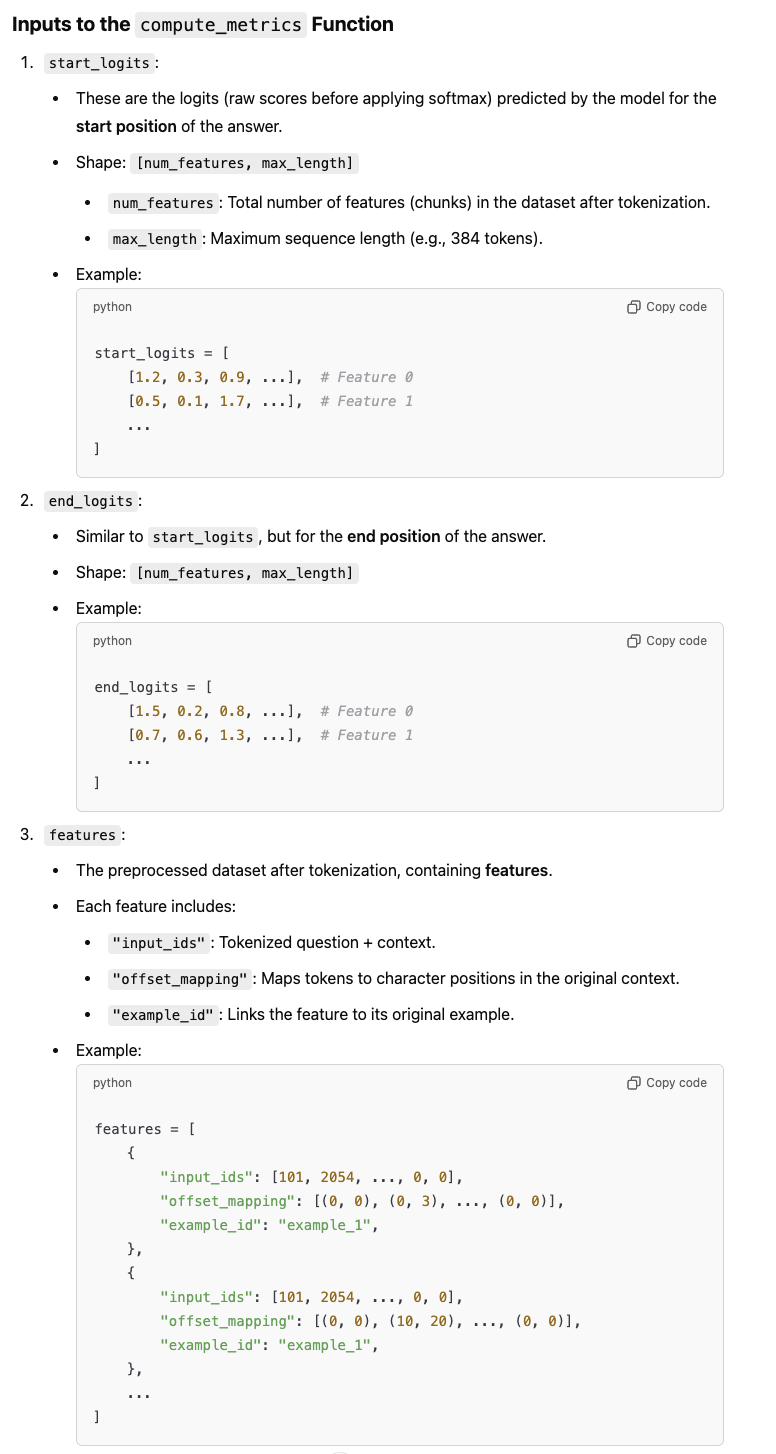

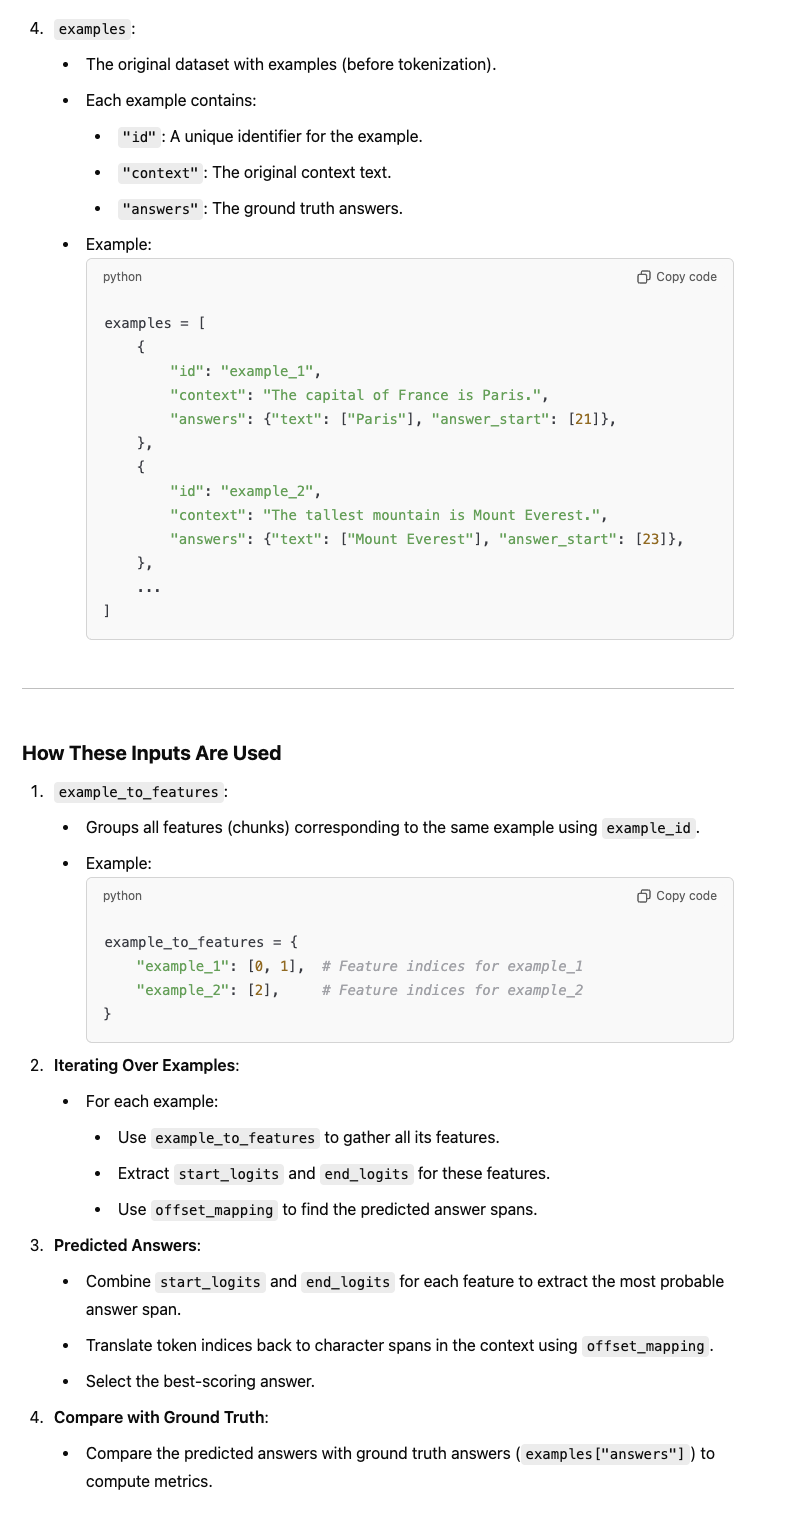

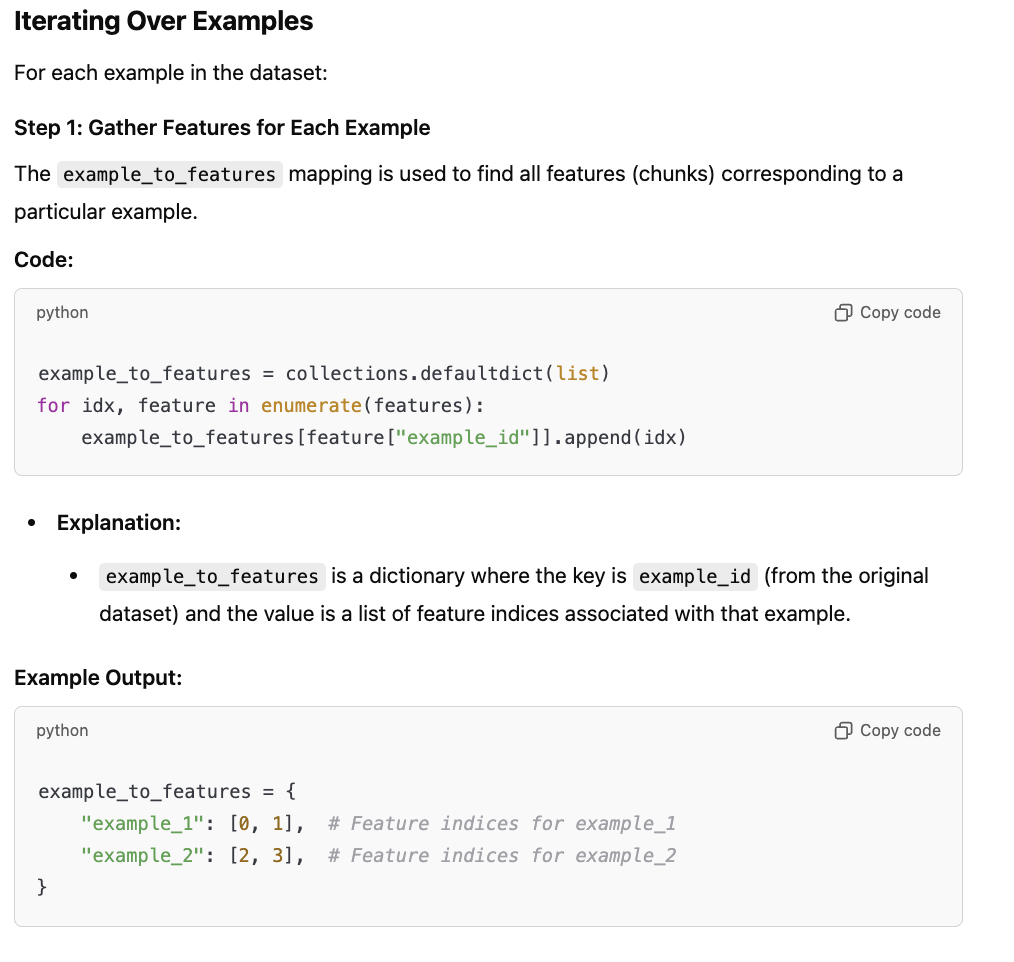

for feature 0, we extract top scores of start and end tokens
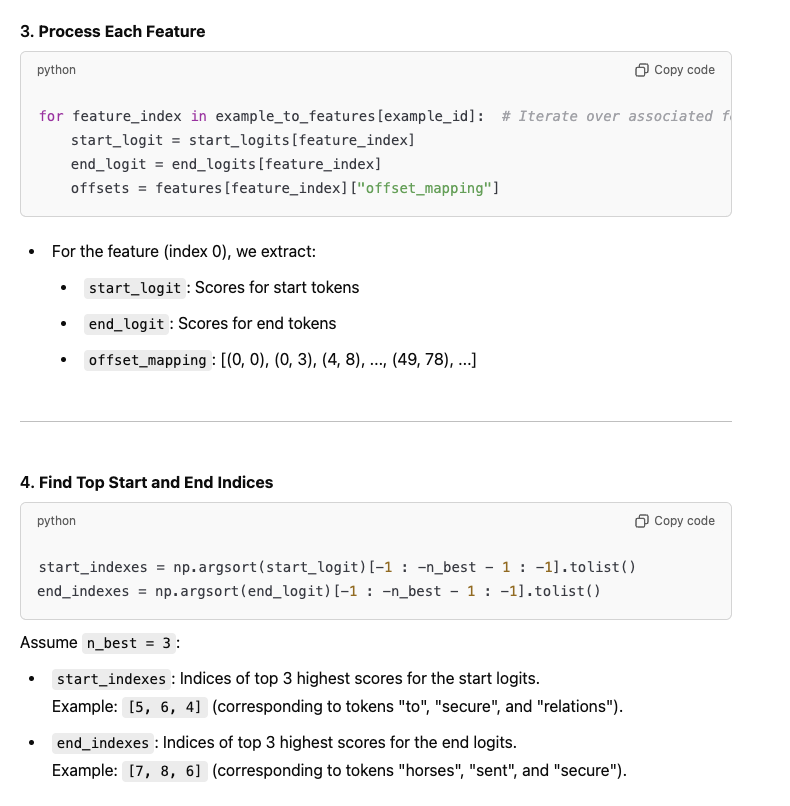

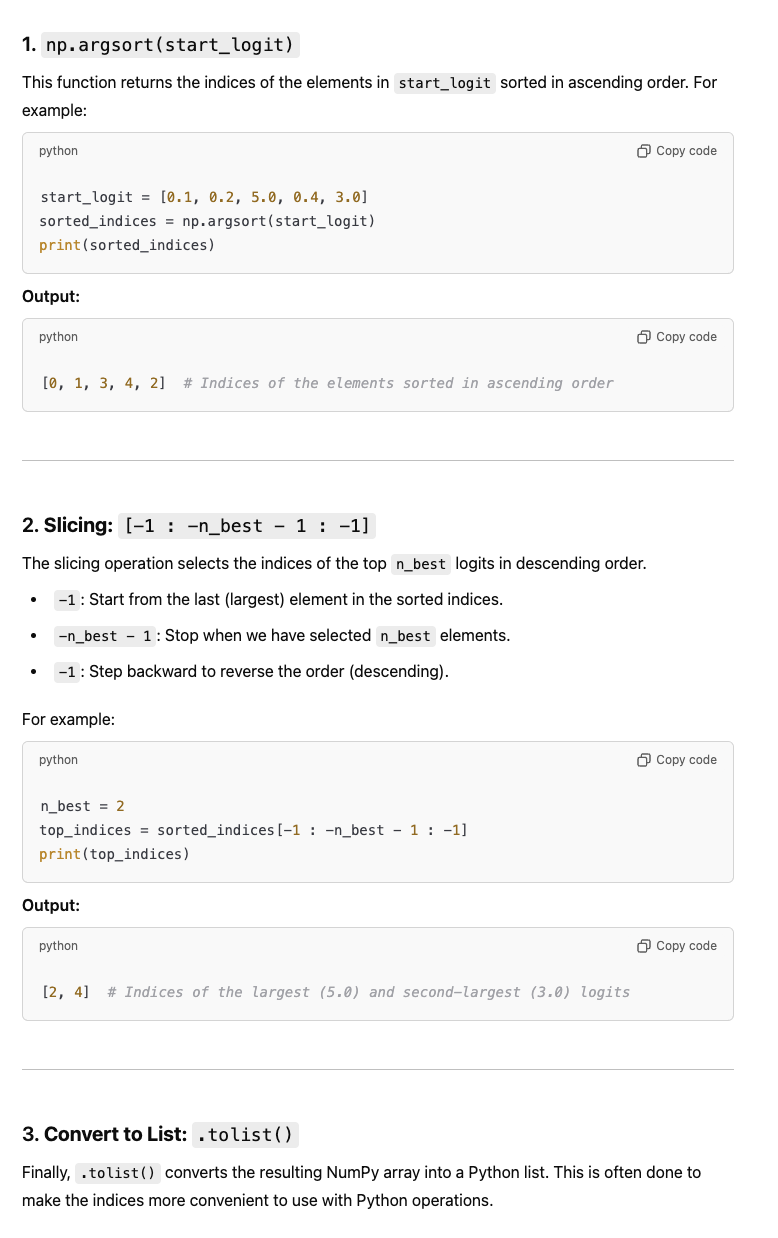

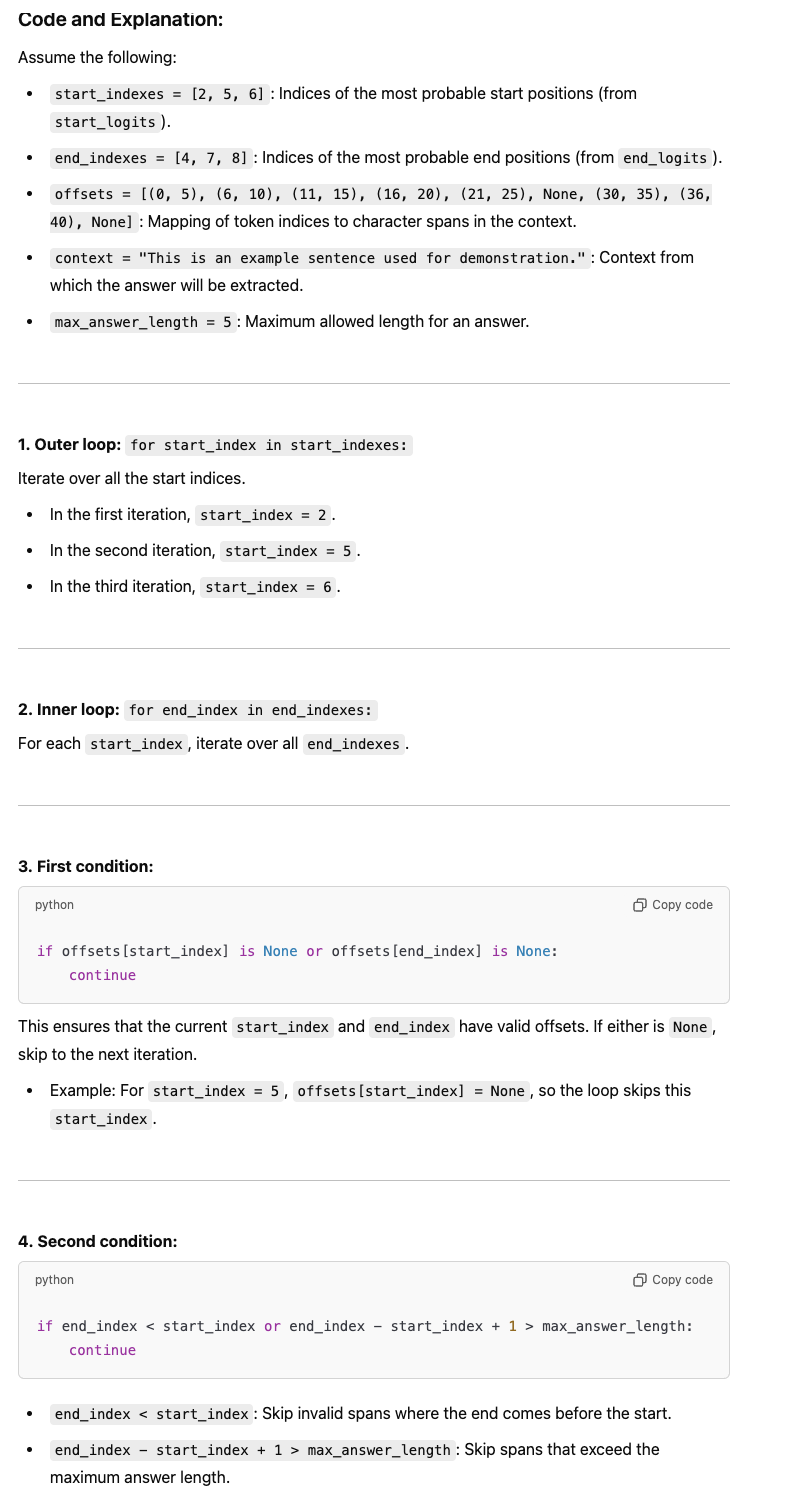

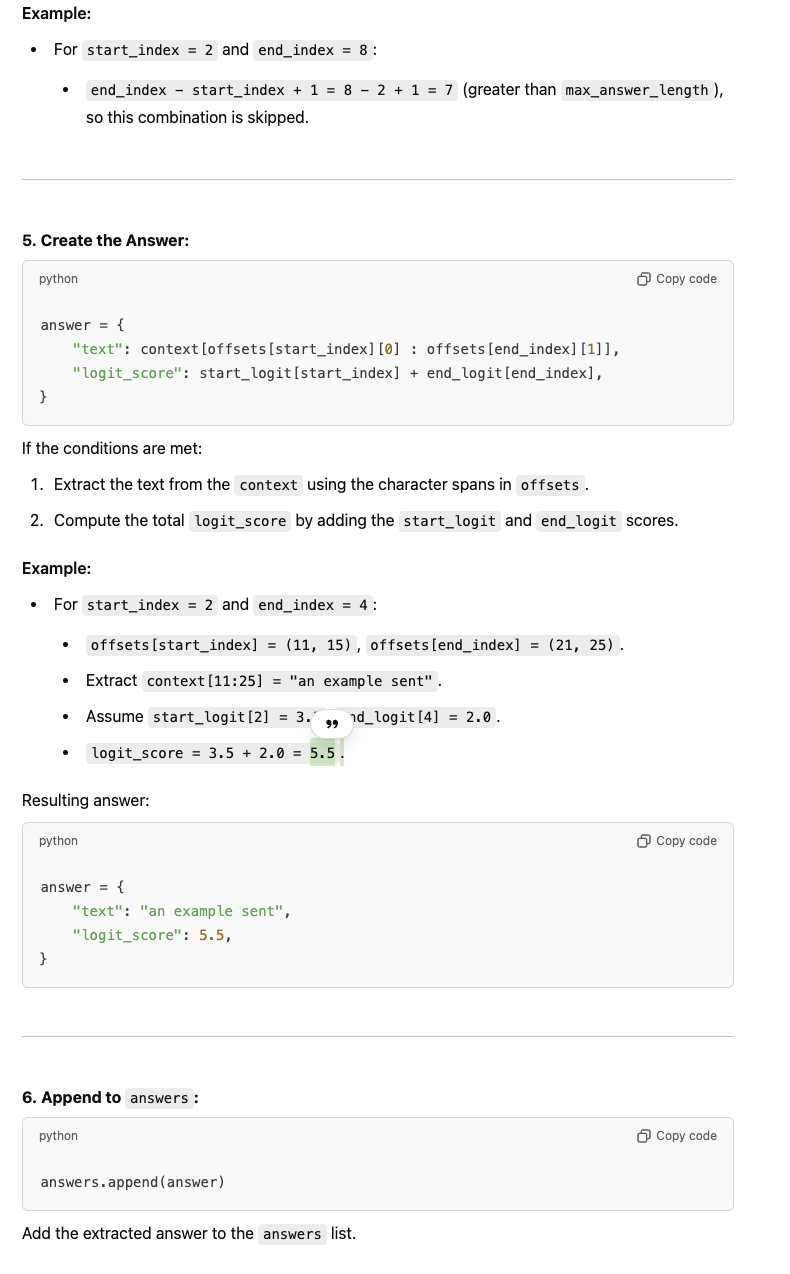

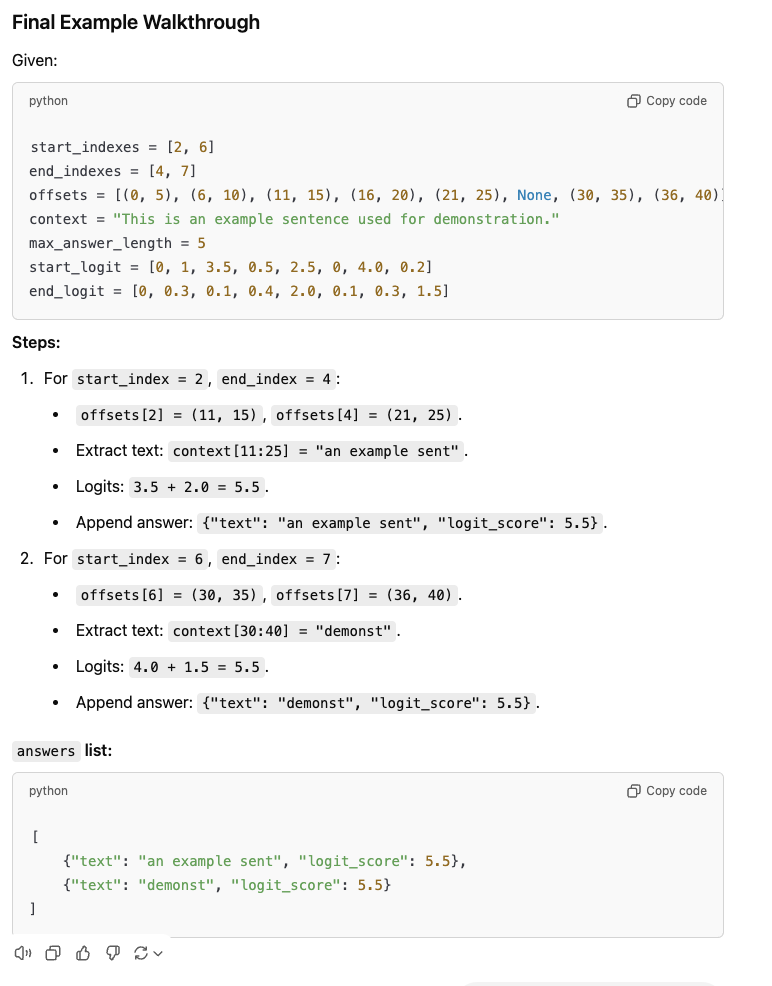

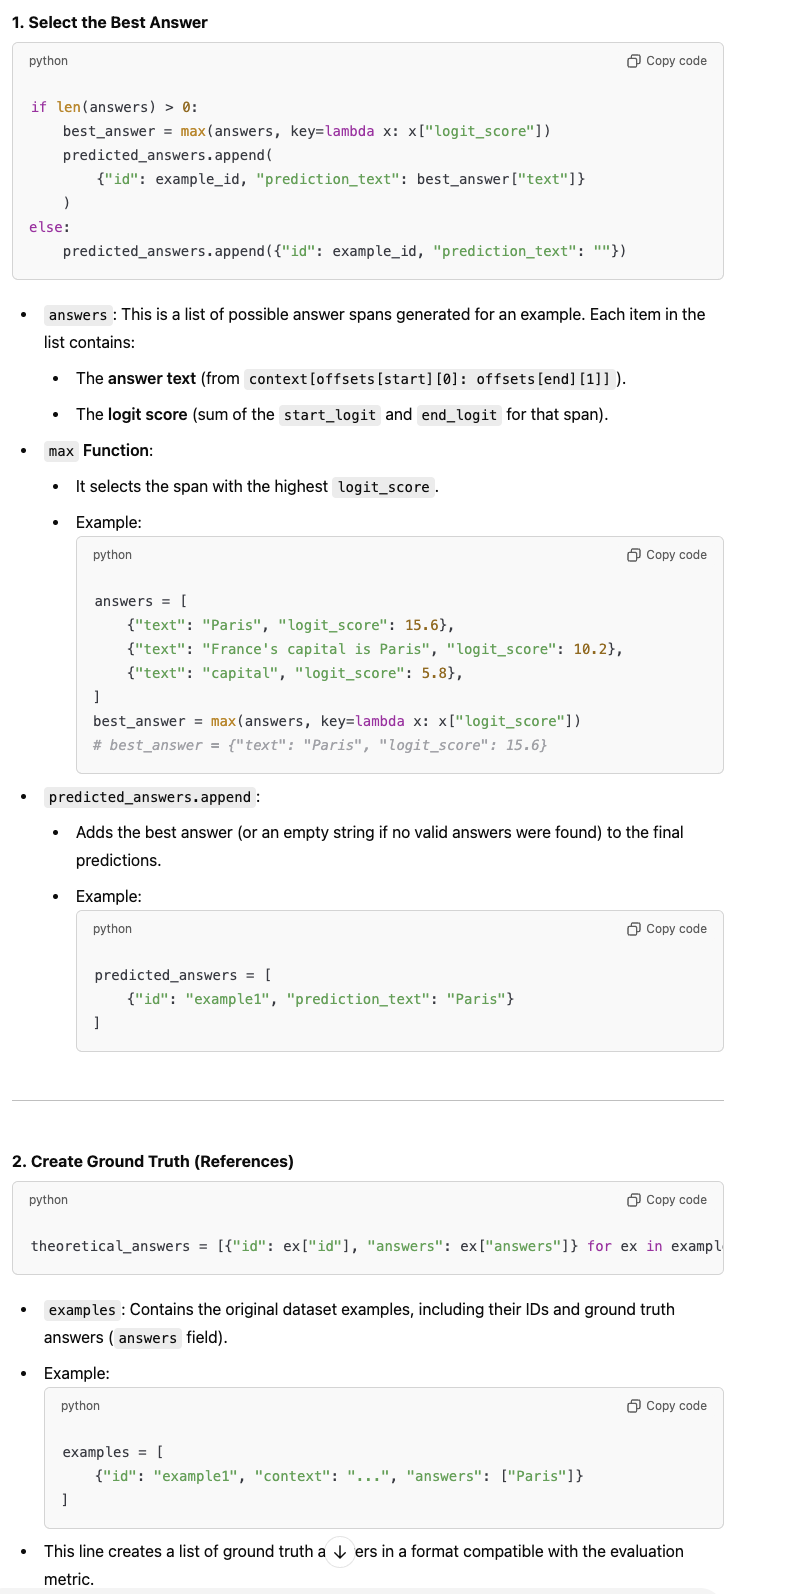

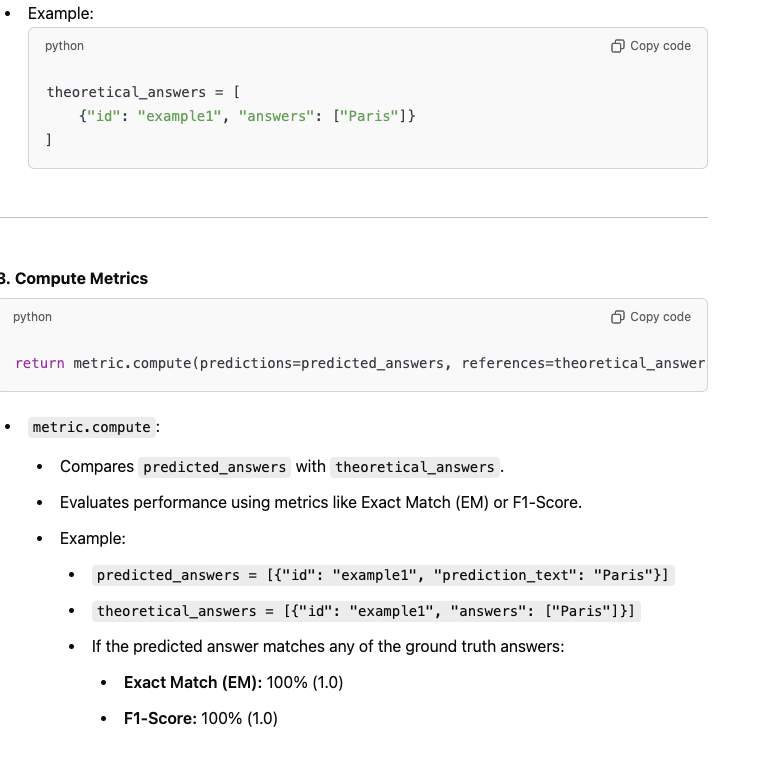

In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
answers

In [ ]:
# Imports
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, get_scheduler
from torch.utils.data import DataLoader
from accelerate import Accelerator
from huggingface_hub import Repository, get_full_repo_name
from tqdm.auto import tqdm
import torch
import numpy as np
import collections

# Parameters
max_length = 384
stride = 128
batch_size = 8
num_train_epochs = 3
n_best = 20
max_answer_length = 30

# Load Tokenizer and Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Preprocess Training Examples
def preprocess_training_examples(examples):
    # Clean up questions before tokenizing
    questions = [q.strip() for q in examples["question"]]

    # Tokenize the inputs with specific parameters
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Extract offset mapping and sample map
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    # Track the last processed sample index
    last_sample_idx = -1

    for i, offset in enumerate(offset_mapping):
        # Check which sample the current chunk belongs to
        sample_idx = sample_map[i]

        # If we're processing a new sample, reset the answer found flag
        if sample_idx != last_sample_idx:
            last_sample_idx = sample_idx

        # Extract the answer details for the current sample
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])

        # Identify the context boundaries using sequence IDs
        sequence_ids = inputs.sequence_ids(i)

        # Find where the context starts and ends
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx

        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Check if the answer is fully inside the chunk
        if offset[context_start][0] <= start_char and offset[context_end][1] >= end_char:
            # The answer is fully inside the chunk; find its start and end positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
        else:
            # If the answer is not in this chunk, append (0, 0)
            start_positions.append(0)
            end_positions.append(0)

    # Add start and end positions to the inputs
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

# Compute Metrics Function
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

# Prepare Dataset
train_dataset = ...  # Load your training dataset here
validation_dataset = ...  # Load your validation dataset here

train_dataset = train_dataset.map(preprocess_training_examples, batched=True)
validation_dataset = validation_dataset.map(preprocess_training_examples, batched=True)

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)
eval_dataloader = DataLoader(
    validation_set, batch_size=batch_size
)

# Accelerator Setup
accelerator = Accelerator(fp16=True)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

# Learning Rate Scheduler
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Repository Setup for Saving
model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
output_dir = "bert-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

# Training and Evaluation Loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

# Final Save
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
